## validation

### The unique ID is comprised of exactly 5 digits  

### The latitude or longitude are numbers within acceptable ranges (the latitude should be between -90 and 90, the longitude between -180 and 180)  

### The year is an integer number that makes sense (e.g. not in the future)  

### The political unit is a string of length 2, composed only of capital letters or the special value ”99” (indicating an unknown unit)  

### The validity of any arguments should also be checked when calling the methods of Glacier and GlacierCollection or the haversine_distance function. This includes, in particular, the latitude and longitude, as well as the code pattern for filter_by_code. The mass-balance value should also be a valid number.

### Finally, when reading the mass-balance data file, you should check that all the glaciers referred to have already been defined (when creating the collection). Your code should throw an error if an unrecognised glacier identifier is encountered.

### The error messages should be informative, and you should use an appropriate error type. Avoid messages like “Something has gone wrong” - your goal is to help the users understand what the problem is!

In [263]:
from math import *
def haversine_distance(lat1, lon1, lat2, lon2):
    """Return the distance in km between two points around the Earth.

    Latitude and longitude for each point are given in degrees.
    """
    d = 2 * 6371 * sin(((sin((lat1 - lat2)/2))**2 + cos(lat1) * cos(lat2) * (sin((lon1 - lon2)/2))**2) **1/2)
    return d

In [306]:
def check_id(id_str):
    if len(id_str)==5 and id_str.isdigit():
        return True
    else:
        print('The unique ID should be comprised of exactly 5 digits, but this id is ', id_str)
        return False    
def check_lat_value(value_str):
    try:
        num = float(value_str)
        if num<=90 and num >=-90:
            return True
        else:
            print('The latitude should be between -90 and 90, but this latitude is ',value_str)
            return False
    except:
        print('The latitude should be numeric, but this latitude is ',value_str)
        return False
def check_lon_value(value_str):
    try:
        num = float(value_str)
        if num<=180 and num >=-180:
            return True
        else:
            print('The longitude should be between -180 and 180, but this longitude is ',value_str)
            return False
    except:
        print('The longitude should be numeric, but this longitude is ',value_str)
        return False
def check_year(year_str):
    try:
        year = int(year_str)
        if year <=2021 and year >0:
            return True
        else:
            print('The year should not in the future or negative, but this year is ', year_str)
            return False
    except:
        print('The year should be numeric, and this year is ', year_str)
        return False
def check_unit(unit_str):
    if len(unit_str)==2 and (unit_str=='99' or (unit_str.isupper()and unit_str.isalpha())):
        return True
    else:
        print('The political unit is a string of length 2, composed only of capital letters or the special value 99, and this unit is ', unit_str)
        return False
def check_annual_value(value_str):
    try:
        num = float(value_str)
        if isinstance(num, float):
            return True
        else:
            print('The value for the mass-balance should be numeric, but this value is ', value_str)
            return False
    except:
        print('The value for the mass-balance should be numeric, but this value is ', value_str)
        return False

In [278]:
import csv
import matplotlib.pyplot as plt

In [271]:
class Glacier:
    def __init__(self, glacier_id, name, unit, lat, lon, code):
        self.glacier_id = glacier_id
        self.name = name
        self.unit = unit
        self.lat = lat
        self.lon = lon
        self.code = code
        self.years = []
        self.mass_balances = []
        
    def print_glacier(self):
        print(self.glacier_id,self.name,self.unit,self.lat,self.lon,self.code,self.years, self.mass_balances)
        
    def add_mass_balance_measurement(self, year, mass_balance,is_partial):
        if year not in self.years:
            self.years.append(year)
            self.mass_balances.append(float(mass_balance))
        elif is_partial == True:
            sum_value = self.mass_balances[self.years.index(year)]+float(mass_balance)
            self.mass_balances[self.years.index(year)] = sum_value

    def plot_mass_balance(self, output_path):
        years = self.years
        mass_balance = self.mass_balances
        plt.plot(years, mass_balance)
        plt.xlabel("Year")
        plt.ylabel("Mass_balance")
        plt.show()
        plt.savefig(output_path)

In [332]:
class GlacierCollection:

    def __init__(self, file_path):
        self.collection = []
        with open(file_path, newline='') as csvfile: 
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            next(spamreader)
            for row in spamreader:
                if check_id(row[2]) and check_lat_value(row[5]) and check_lon_value(row[6]) and check_unit(row[0]):
                    glacier = Glacier(row[2], row[1], row[0], float(row[5]), float(row[6]), int(row[7]+row[8]+row[9]))
                    self.collection.append(glacier)
        
    
    def read_mass_balance_data(self, file_path):
        with open(file_path, newline='') as csvfile: 
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            next(spamreader)
            for row in spamreader:
                for glacier in self.collection:
                    if row[2]==glacier.glacier_id:
                        if check_annual_value(row[-3]) and check_year(row[3]):
                            if row[4] == '9999':
                                glacier.add_mass_balance_measurement(row[3], row[-3],False)
                            else:
                                glacier.add_mass_balance_measurement(row[3], row[-3],True)
#                         else:
#                             print('The annual value of glacier ',row[2],' in year ',row[3],' is not digit, it is ',row[-3] )
        
                
        

    def find_nearest(self, lat, lon, n=5):
        dis_list = []
        name_list = []
        top_name = []
        if check_lat_value(lat) and check_lon_value(lon):
            for glacier in self.collection:
                lon1 = glacier.lon
                lat1 = glacier.lat
                dis_list.append(haversine_distance(float(lat), float(lon), float(lat1), float(lon1)))
                name_list.append(glacier.name)
        dis_copy = dis_list.copy()
        dis_copy.sort()
        top_n = dis_copy[:n]
        i = 0    
        for i in top_n:
            top_name.append(name_list[dis_list.index(i)])
        return top_name[:n] 
    
    def filter_by_code(self, code_pattern):
        """Return the names of glaciers whose codes match the given pattern."""
        raise NotImplementedError

    def sort_by_latest_mass_balance(self, n=5, reverse=True):
        """Return the N glaciers with the highest area accumulated in the last measurement."""
        mass_balance_list = []
        name_list = []
        top_name = []
        
        
        for glacier in self.collection:
            if glacier.mass_balances == []:
                mass_balance = 0
            else:
                mass_balance = glacier.mass_balances[-1]
            mass_balance_list.append(mass_balance)
            name_list.append(glacier.name)
        dis_copy = mass_balance_list.copy()
        
        if reverse == True:
            dis_copy.sort(reverse = True)
        else:
            dis_copy.sort()
            
        top_n = dis_copy[:n]
        i = 0    
        for i in top_n:
            top_name.append(name_list[mass_balance_list.index(i)])
        return top_name[:n]
        

    def summary(self):
        num_Glaciers = len(self.collection)
       
        years=[]
        for glacier in self.collection:
            years.extend(glacier.years)
        
        earlist_recorded_year = min(years)
        
        shrunk_sum = 0
        glacier_sum = 0
        for i in self.collection:
            if i.mass_balances != []:
                glacier_sum = glacier_sum + 1
                if i.mass_balances[-1]< 0:
                    shrunk_sum = shrunk_sum + 1
           
        percentage_shrunk = int(shrunk_sum/glacier_sum * 100)
        
        print("This collection has", num_Glaciers, "glaciers.")
        print("The earliest measurement was in ", earlist_recorded_year, " .")
        print(percentage_shrunk, "% " , "of glaciers shrunk in their last measurement" )

    def plot_extremes(self, output_path):
        raise NotImplementedError


## 实例化

In [333]:
Glaciers = GlacierCollection('sheet-A.csv')
Glaciers.read_mass_balance_data('sheet-EE.csv')
Glaciers.summary()

The unique ID should be comprised of exactly 5 digits, but this id is   VADRET DA"
The unique ID should be comprised of exactly 5 digits, but this id is   VADRET"
The value for the mass-balance should be numeric, but this value is  
The value for the mass-balance should be numeric, but this value is  
The value for the mass-balance should be numeric, but this value is  
The value for the mass-balance should be numeric, but this value is  
The value for the mass-balance should be numeric, but this value is  
The value for the mass-balance should be numeric, but this value is  
The value for the mass-balance should be numeric, but this value is  
The value for the mass-balance should be numeric, but this value is  
The value for the mass-balance should be numeric, but this value is  
The value for the mass-balance should be numeric, but this value is  
The value for the mass-balance should be numeric, but this value is  
The value for the mass-balance should be numeric, but this value is

The value for the mass-balance should be numeric, but this value is  
The value for the mass-balance should be numeric, but this value is  
The value for the mass-balance should be numeric, but this value is  
The value for the mass-balance should be numeric, but this value is  
The value for the mass-balance should be numeric, but this value is  
The value for the mass-balance should be numeric, but this value is  
The value for the mass-balance should be numeric, but this value is  
The value for the mass-balance should be numeric, but this value is  
The value for the mass-balance should be numeric, but this value is  
The value for the mass-balance should be numeric, but this value is  
The value for the mass-balance should be numeric, but this value is  
The value for the mass-balance should be numeric, but this value is  
The value for the mass-balance should be numeric, but this value is  
The value for the mass-balance should be numeric, but this value is  
The value for the ma

In [328]:
Glaciers.collection

 ...]

In [327]:
Glaciers.summary()

AttributeError: 'GlacierCollection' object has no attribute 'colleciton'

## Test
• Errors with appropriate error messages are thrown when invalid values are encountered (see Validation
section above) 

• The add_mass_balance_measurement method works correctly for both partial and whole-region data, as explained above  

• The filter_by_code method works correctly for both full codes and incomplete code patterns (containing ?) 

• The sort_by_latest_mass_balance method works correctly for both directions of sorting (i.e. for both values of the reverse argument)

In [317]:
import pytest
def test_id():
    assert check_id('123')== False
    assert check_id('8t123')== False
    assert check_id('123--')== False
    assert check_id('12345')== True
def test_lat_value():
    assert check_lat_value(-91)== False
    assert check_lat_value('-91')== False
    assert check_lat_value(90)== True
    assert check_lat_value('0')== True
def test_lon_value():
    assert check_lon_value(-181)== False
    assert check_lon_value('-181')== False
    assert check_lon_value(180)== True
    assert check_lon_value('0')== True
def test_year():
    assert check_year(1998) == True
    assert check_year('1998') == True
    assert check_year('0') == False
    assert check_year('-1900') == False
    assert check_year('19000') == False
def test_annual_value():
    assert check_annual_value(1900) == True
    assert check_annual_value(19.00) == True
    assert check_annual_value(-1900) == True
    assert check_annual_value('-19.00') == True
    assert check_annual_value('') == False
    assert check_annual_value('---') == False

In [319]:
test_id()
test_lat_value()
test_lon_value()
test_year()
test_annual_value()

The unique ID should be comprised of exactly 5 digits, but this id is  123
The unique ID should be comprised of exactly 5 digits, but this id is  8t123
The unique ID should be comprised of exactly 5 digits, but this id is  123--
The year should not in the future or negative, but this year is  0
The year should not in the future or negative, but this year is  -1900
The year should not in the future or negative, but this year is  19000
The value for the mass-balance should be numeric, but this value is  
The value for the mass-balance should be numeric, but this value is  ---


In [286]:
Glaciers.sort_by_latest_mass_balance(4,False)

['ARTESONRAJU', 'TUNSBERGDALSBREEN', 'PARLUNG NO. 94', 'GRAAFJELLSBREA']

In [264]:
 def find_nearest(self, lat, lon, n=5):
        dis_list = []
        name_list = []
        top_name = []
        if check_lat_value(lat) and check_lon_value(lon):
            for glacier in self.collection:
                lon1 = glacier.lon
                lat1 = glacier.lat
                dis_list.append(haversine_distance(float(lat), float(lon), float(lat1), float(lon1)))
                name_list.append(glacier.name)
        dis_copy = dis_list.copy()
        dis_copy.sort()
        top_n = dis_copy[:n]
        i = 0    
        for i in top_n:
            top_name.append(name_list[dis_list.index(i)])
        return top_name[:n]              

In [267]:
Glaciers.find_nearest(0,50)

['KALDALONSJOKULL',
 'DRANGAJOKULL ICE CAP',
 'COROPUNA',
 'REYKJAFJARDARJOKULL',
 'LEIRUFJARDARJOKULL']

In [226]:
import re

In [233]:
glaciers = []
i = 0
for glacier in Glaciers.collection:
    g

01347 FRIAS AR -41.15 -71.83 538 [] []
01661 FRIAS AR -50.75 -75.08 428 [] []


## print 冰川数据

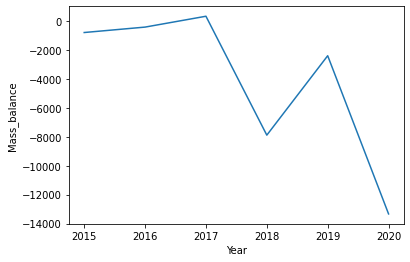

1


<Figure size 432x288 with 0 Axes>

In [281]:
glaciers = []
i = 0
for glacier in Glaciers.collection:
    if glacier.glacier_id in no_repeat_EE_id:
        glacier.plot_mass_balance('a.png')
        i = i+1
    if i>0:
        break
print(i)

## 注意 sheet A中存在一个name为FRIAS的冰川 出现两次，它们的id不同

In [42]:
from collections import Counter   #引入Counter
a = glaciers
b = dict(Counter(a))
print ([key for key,value in b.items()if value > 1])  #只展示重复元素
print ({key:value for key,value in b.items()if value > 1})  #展现重复元素和重复次数

['FRIAS']
{'FRIAS': 2}


## 在sheet EE中，仅有56个冰川有数据记录，其中不包含FRIAS冰川

In [60]:
id_list =[]
with open('sheet-EE.csv', newline='') as csvfile: 
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    next(spamreader)
    for row in spamreader:
        id_list.append(row[2])
no_repeat_EE_id = list(set(id_list))

In [65]:
a = glaciers
b = no_repeat_EE_id
c=[x for x in a if x in b]
d=[y for y in (a+b) if y not in c]
print(len(c))
print(len(d))
print(len(a))
print(len(b))

56
1638
1694
56
